# Plot river profiles for the base level samples and adjacent tributaries/rivers

In [7]:
from TopoAnalysis import dem as d
import matplotlib.pylab as plt
from TopoAnalysis.plotting import plot_recursive_upstream_profiles
import numpy as np
import os
import pandas as pd

In [8]:
new_directory_path = "/Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver"  
os.chdir(new_directory_path)
print("New working directory:", os.getcwd())

New working directory: /Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver


In [3]:
# outlets in utm 19S
outlets = {'rapel': {'RP-S2': [246249.2076, 6240448.447],
                    'RP-S3': [250212.9354, 6237948.848],
                    'RP-S3u': [250603.5211, 6228481.157],
                    'RP-S4u': [262281.9748, 6217862.614]}
          }

In [9]:
dem = d.Elevation.load('rapel_SRTMGL130m_dem_utm.tif')
print('dem loaded')
filled = d.Elevation.load('rapel_dem_utm_filled30m')
print('filled loaded')
area = d.Area.load('rapel_area_utm30m')
print('area loaded')
fd = d.FlowDirectionD8(flooded_dem = filled)
print('fd loaded')

dem loaded
filled loaded
area loaded
fd loaded


Figure saved to: /Users/Glong1/Desktop/Andes/AndesTG/Rapel/base_level/Figures/rapel_profiles.png


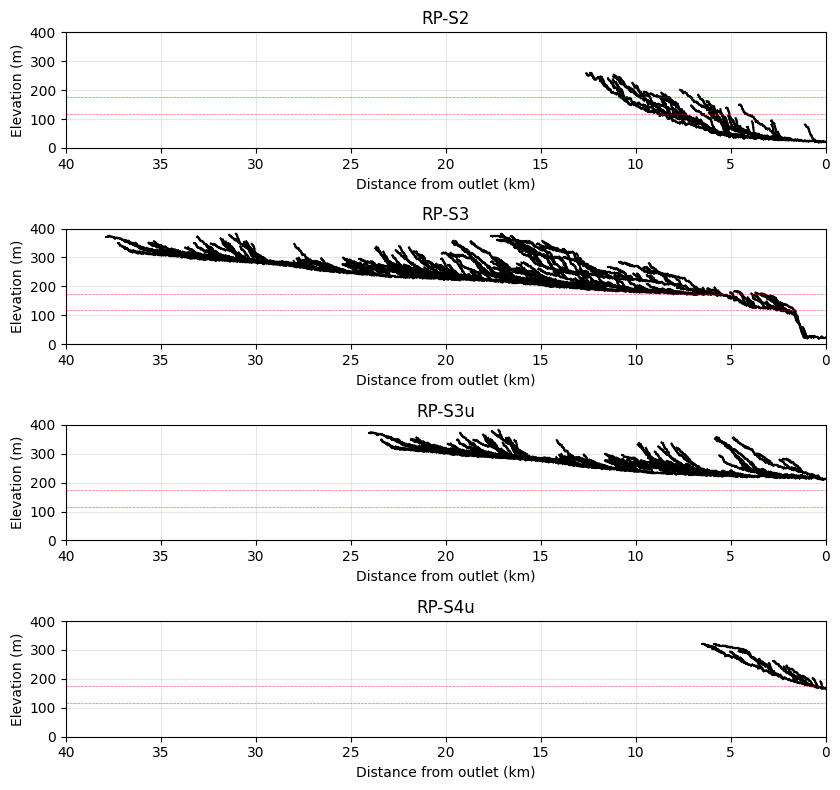

In [6]:
# Plotting all river profiles sampled
def fix_indices_recursive(ld_item):
    """Fix malformed indices if they're wrapped in a tuple"""
    if isinstance(ld_item['index'], tuple) and len(ld_item['index']) == 1:
        ld_item['index'] = ld_item['index'][0]
    
    if ld_item.get('next'):
        for next_item in ld_item['next']:
            fix_indices_recursive(next_item)

def plot_upstream_profile(ld_list, minimum_area=1E5):
    """Plot river profile moving upstream"""
    def plot_recursive(current_distance, ld_item):
        if ld_item.get('next'):
            for next_item in ld_item['next']:
                if next_item['area'] >= minimum_area:
                    # Calculate distance to next point
                    current_row, current_col = ld_item['index']
                    next_row, next_col = next_item['index']
                    
                    # Diagonal movement is longer (sqrt(2) ≈ 1.414)
                    if (current_row != next_row) and (current_col != next_col):
                        distance_increment = ld_item['de'] * 1.414
                    else:
                        distance_increment = ld_item['de']
                    
                    next_distance = current_distance + distance_increment
                    
                    # Draw line segment (convert meters to km)
                    plt.plot([current_distance/1000, next_distance/1000], 
                           [ld_item['elevation'], next_item['elevation']], 
                           'k-')
                    
                    # Continue upstream
                    plot_recursive(next_distance, next_item)
    
    plot_recursive(0.0, ld_list)

# Setup mean pixel dimension
mean_pixel_dimension = d.BaseSpatialGrid()
mean_pixel_dimension._copy_info_from_grid(area, True)
mean_pixel_dimension._griddata = area._mean_pixel_dimension()

# Create figure with 4 subplots (one for each outlet)
fig, axs = plt.subplots(4, figsize=(8.5, 8))

for i, (outlet_name, outlet_coords) in enumerate(outlets['rapel'].items()):
    plt.sca(axs[i])
    
    # Get river network data
    ld_list = fd.map_values_to_recursive_list(
        outlet_coords, 
        elevation=dem, 
        area=area, 
        de=mean_pixel_dimension
    )
    fix_indices_recursive(ld_list)
    
    # Plot the profile
    plot_upstream_profile(ld_list, minimum_area=1E5)

    # Add dashed line at 175 m
    axs[i].axhline(y=175, color='red', linestyle='--', linewidth=0.5, alpha=0.6)
    axs[i].axhline(y=117, color='red', linestyle='--', linewidth=0.5, alpha=0.6)

    # Format the plot
    axs[i].set_xlim([40, 0])
    axs[i].set_ylim([0, 400])
    axs[i].grid(True, alpha=0.3)
    axs[i].set_xlabel('Distance from outlet (km)')
    axs[i].set_ylabel('Elevation (m)')
    axs[i].set_title(outlet_name)

plt.tight_layout()

# Save figure (set to where you want to save file)
save_dir = '/Users/Glong1/Desktop/Andes/AndesTG/Rapel/base_level/Figures'
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, 'rapel_profiles.png')
plt.savefig(save_path)
print(f'Figure saved to: {os.path.abspath(save_path)}')
plt.show()

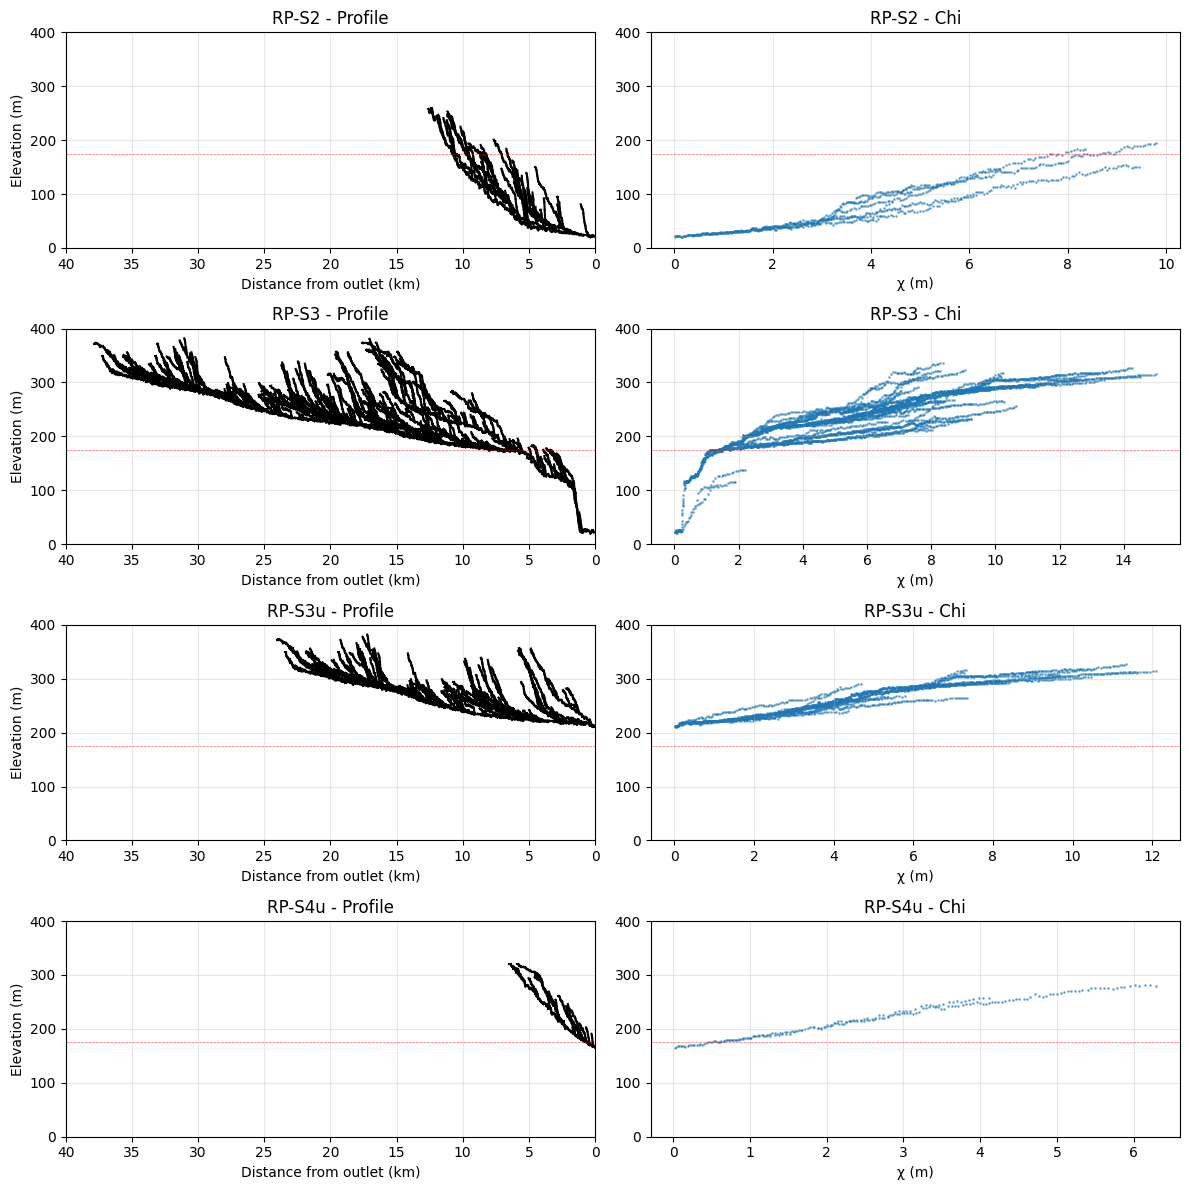

In [11]:
# Plotting both chi elevation and distance elevation plots

# Load data
area = d.Area.load('/Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/rapel_area_utm30m')
fd = d.FlowDirectionD8.load('/Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/rapel_fd_utm30m')
elevation = d.Elevation.load('/Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/rapel_SRTMGL130m_dem_utm.tif')
filled = d.Elevation.load('rapel_dem_utm_filled30m')

# Setup
outlets = [
    (246249.2076, 6240448.447),
    (250212.9354, 6237948.848),
    (250603.5211, 6228481.157),
    (262281.9748, 6217862.614)
]
samples = ['RP-S2', 'RP-S3', 'RP-S3u', 'RP-S4u']

mean_pixel_dimension = d.BaseSpatialGrid()
mean_pixel_dimension._copy_info_from_grid(area, True)
mean_pixel_dimension._griddata = area._mean_pixel_dimension()

def fix_indices_recursive(ld_item):
    if isinstance(ld_item['index'], tuple) and len(ld_item['index']) == 1:
        ld_item['index'] = ld_item['index'][0]
    if ld_item.get('next'):
        for next_item in ld_item['next']:
            fix_indices_recursive(next_item)

def plot_upstream_profile(ld_item, current_distance=0.0, minimum_area=1E5):
    if ld_item.get('next'):
        for next_item in ld_item['next']:
            if next_item['area'] >= minimum_area:
                current_row, current_col = ld_item['index']
                next_row, next_col = next_item['index']
                
                distance_increment = ld_item['de'] * (1.414 if current_row != next_row and current_col != next_col else 1)
                next_distance = current_distance + distance_increment
                
                plt.plot([current_distance/1000, next_distance/1000], 
                        [ld_item['elevation'], next_item['elevation']], 'k-')
                
                plot_upstream_profile(next_item, next_distance, minimum_area)

# Create figure with 4 rows, 2 columns
fig, axs = plt.subplots(4, 2, figsize=(12, 12))

for i, (outlet, sample) in enumerate(zip(outlets, samples)):
    # Distance plot (left column)
    ld_list = fd.map_values_to_recursive_list(outlet, elevation=elevation, area=area, de=mean_pixel_dimension)
    fix_indices_recursive(ld_list)
    
    plt.sca(axs[i, 0])
    plot_upstream_profile(ld_list, minimum_area=1E5)
    axs[i, 0].set_xlim([40, 0])
    axs[i, 0].set_ylim([0, 400])
    axs[i, 0].set_xlabel('Distance from outlet (km)')
    axs[i, 0].set_ylabel('Elevation (m)')
    axs[i, 0].set_title(f'{sample} - Profile')
    axs[i, 0].grid(True, alpha=0.3)
    axs[i, 0].axhline(y=175, color='red', linestyle='--', linewidth=0.5, alpha=0.6)
    
    # Chi plot (right column)
    chi_single = d.Chi(flow_direction=fd, area=area, theta=0.45, Ao=1, outlets=[outlet])
    chi_data = chi_single._griddata[chi_single._griddata > 0]
    elev_data = elevation._griddata[chi_single._griddata > 0]
    area_data = area._griddata[chi_single._griddata > 0]
    mask_out = area_data >= 1e6
    
    axs[i, 1].scatter(chi_data[mask_out], elev_data[mask_out], s=1, alpha=0.5)
    axs[i, 1].set_xlabel('χ (m)')
    #axs[i, 1].set_ylabel('Elevation (m)')
    axs[i, 1].set_ylim([0, 400])
    axs[i, 1].set_title(f'{sample} - Chi')
    axs[i, 1].grid(True, alpha=0.3)
    axs[i, 1].axhline(y=175, color='red', linestyle='--', linewidth=0.5, alpha=0.6)

plt.tight_layout()
save_path = 'Figures/rapel_combined_plots.png'
os.makedirs('Figures', exist_ok=True)
plt.savefig(save_path, dpi=300)
plt.show()

KeyboardInterrupt: 

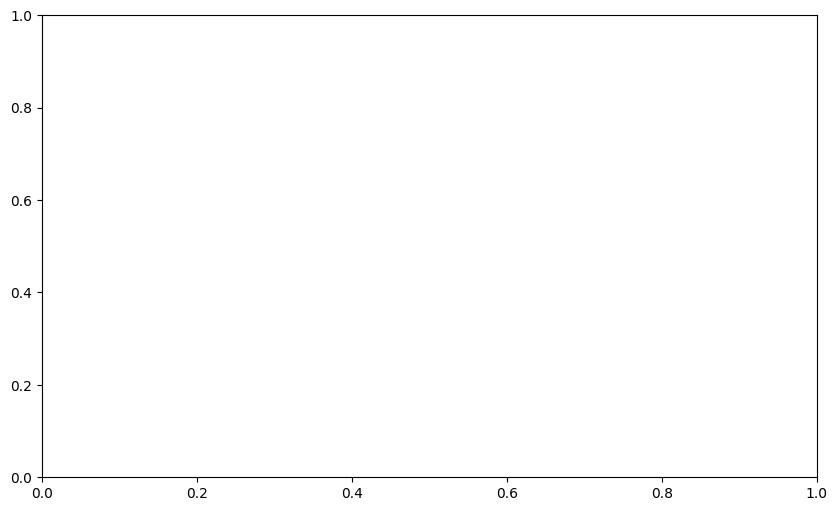

In [6]:
# Plots the river profile for point RP-1 at coordinates [240012.37420, 6244480.71900] to look at the area of the coastal cordillera

outlets = {
    'rapel': {
        'RP-1': [240012.37420, 6244480.71900]
    }
}

def fix_indices_recursive(ld_item):
    """Fix malformed indices if they're wrapped in a tuple"""
    if isinstance(ld_item['index'], tuple) and len(ld_item['index']) == 1:
        ld_item['index'] = ld_item['index'][0]
    
    if ld_item.get('next'):
        for next_item in ld_item['next']:
            fix_indices_recursive(next_item)

def plot_upstream_profile(ld_list, minimum_area=1E5):
    """Plot river profile moving upstream"""
    def plot_recursive(current_distance, ld_item):
        if ld_item.get('next'):
            for next_item in ld_item['next']:
                if next_item['area'] >= minimum_area:
                    # Calculate distance to next point
                    current_row, current_col = ld_item['index']
                    next_row, next_col = next_item['index']
                    
                    # Diagonal movement is longer (sqrt(2) ≈ 1.414)
                    if (current_row != next_row) and (current_col != next_col):
                        distance_increment = ld_item['de'] * 1.414
                    else:
                        distance_increment = ld_item['de']
                    
                    next_distance = current_distance + distance_increment
                    
                    # Draw line segment (convert meters to km)
                    plt.plot([current_distance/1000, next_distance/1000], 
                           [ld_item['elevation'], next_item['elevation']], 
                           'k-')
                    
                    # Continue upstream
                    plot_recursive(next_distance, next_item)
    
    plot_recursive(0.0, ld_list)

# Setup mean pixel dimension
mean_pixel_dimension = d.BaseSpatialGrid()
mean_pixel_dimension._copy_info_from_grid(area, True)
mean_pixel_dimension._griddata = area._mean_pixel_dimension()

# Create single plot
fig, ax = plt.subplots(figsize=(10, 6))

outlet_coords = outlets['rapel']['RP-1']

# Get river network data
ld_list = fd.map_values_to_recursive_list(
    outlet_coords, 
    elevation=dem, 
    area=area, 
    de=mean_pixel_dimension
)
fix_indices_recursive(ld_list)

# Plot the profile
plot_upstream_profile(ld_list, minimum_area=1E5)

# Add dashed line at 175 m
axs[i].axhline(y=175, color='red', linestyle='--', linewidth=0.5, alpha=0.6)
axs[i].axhline(y=117, color='red', linestyle='--', linewidth=0.5, alpha=0.6)

# Format the plot
ax.set_xlim([40, 0])
ax.set_ylim([0, 400])
ax.grid(True, alpha=0.3)
ax.set_xlabel('Distance from outlet (km)')
ax.set_ylabel('Elevation (m)')
ax.set_title('RP-1 Profile')

plt.tight_layout()

# Save figure
"""save_dir = 'Rapel/base_level/Figures'
os.makedirs(save_dir, exist_ok=True)
plt.savefig('Rapel/base_level/Figures/RP-1_profile.png')
print(f'Figure saved to: {os.path.abspath("Rapel/base_level/Figures/RP-1_profile.png")}')"""
plt.show()

# Adjacent tributaries/rivers to samples

In [34]:
# Load tributary coordinates
tributaries = pd.read_csv('/Users/Glong1/Desktop/Andes/AndesTG/Rapel/base_level/base_level_tributaries.csv')

# Convert CSV to outlets dictionary format using the id column as names
outlets = {
    'outlets': {
        str(row['id']): [float(row['x']), float(row['y'])]
        for _, row in tributaries.iterrows()
    }
}

print('loaded csv')

loaded csv


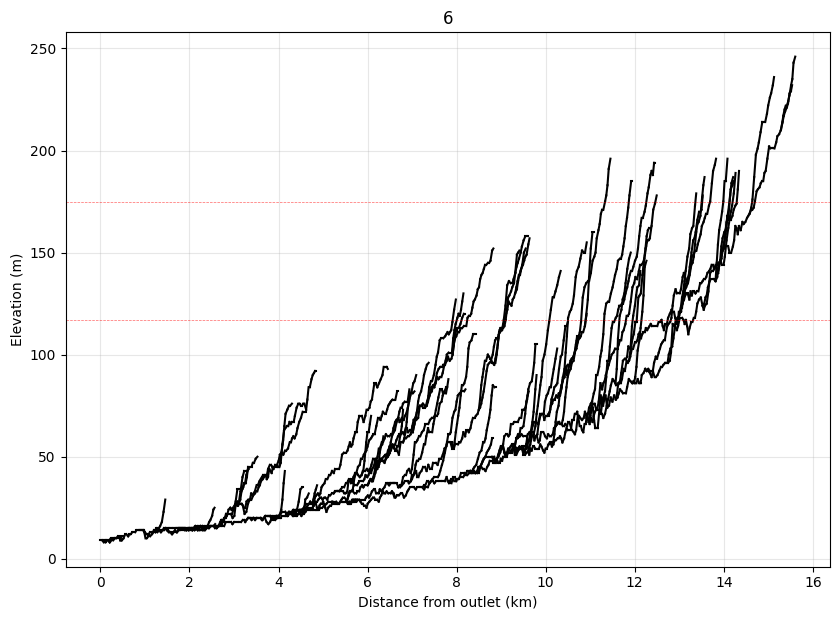

Plotted outlet: 6


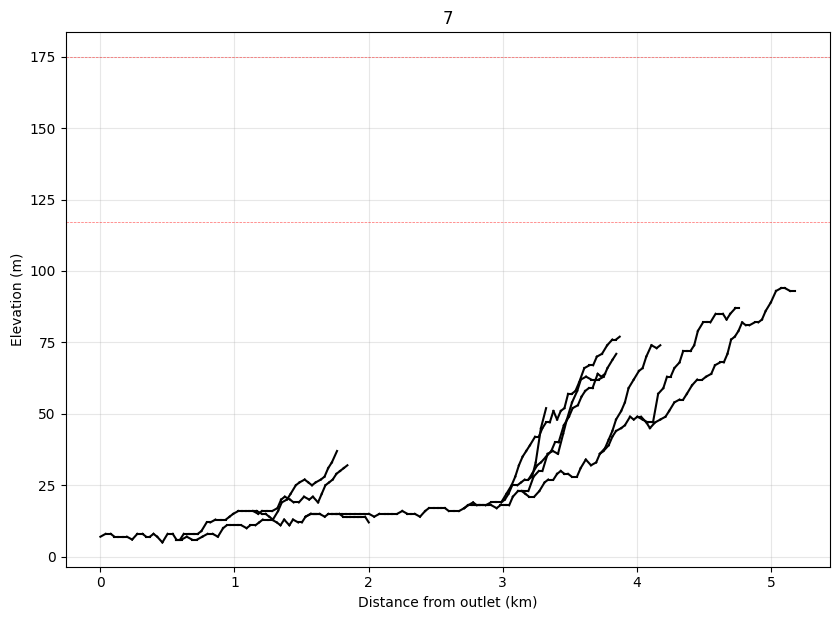

Plotted outlet: 7


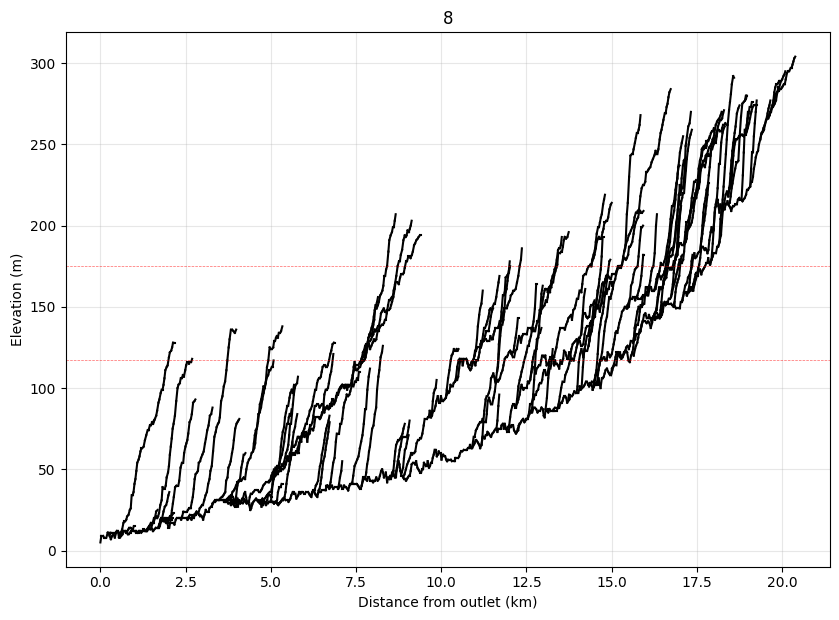

Plotted outlet: 8


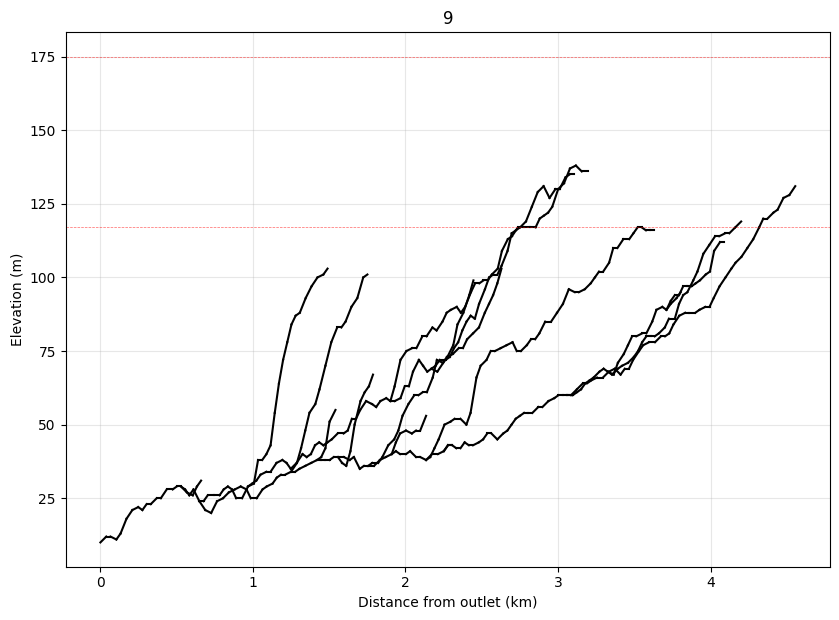

Plotted outlet: 9


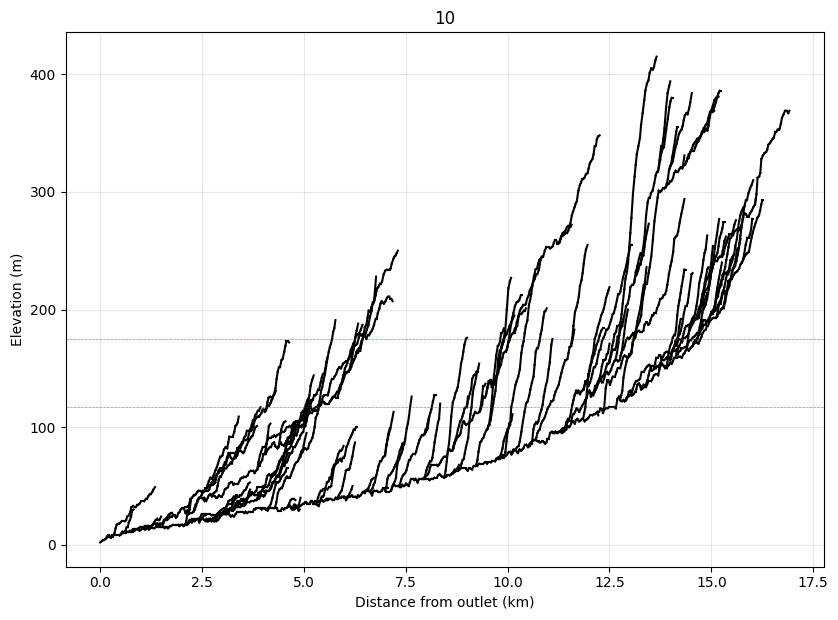

Plotted outlet: 10


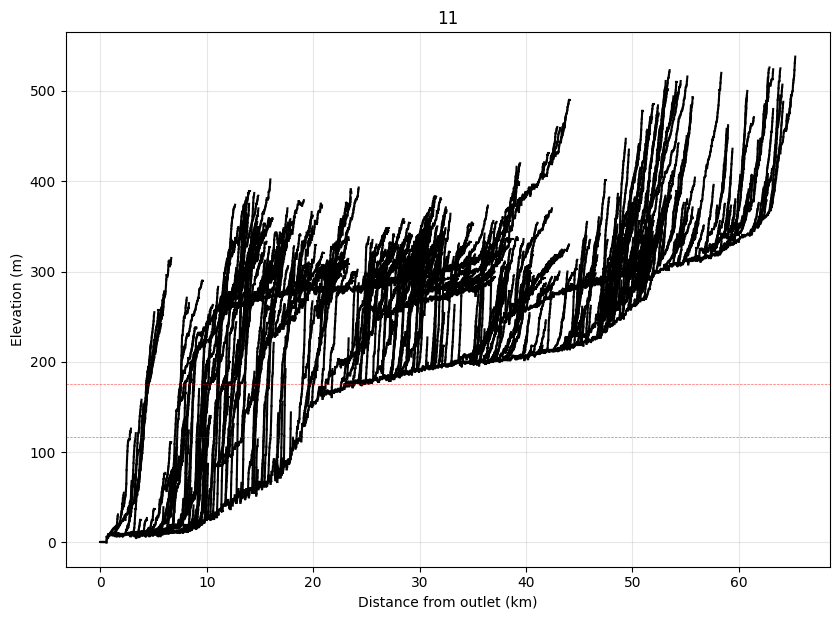

Plotted outlet: 11


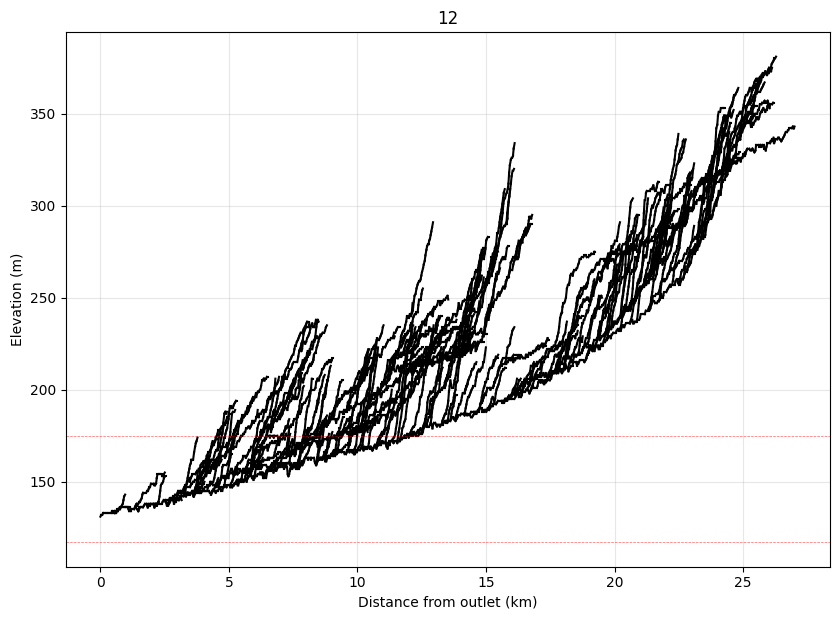

Plotted outlet: 12


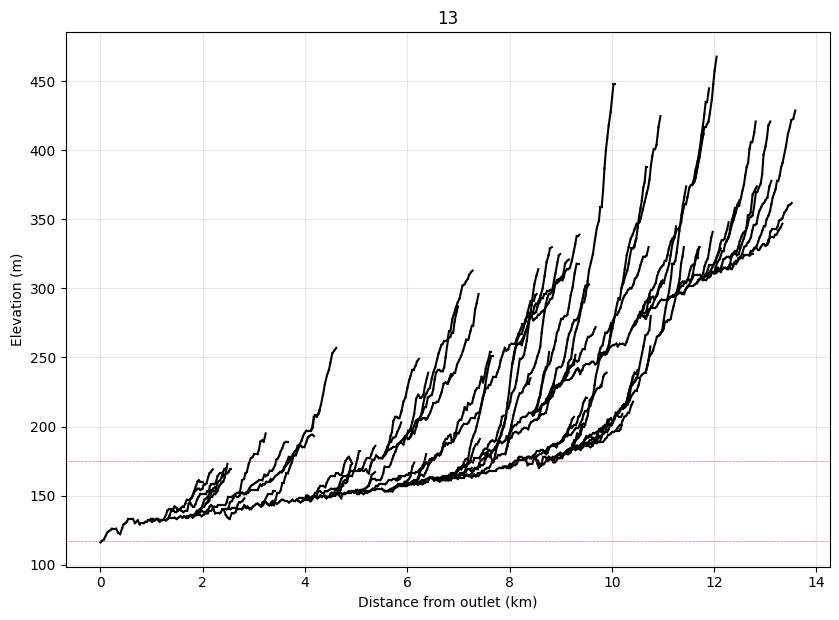

Plotted outlet: 13


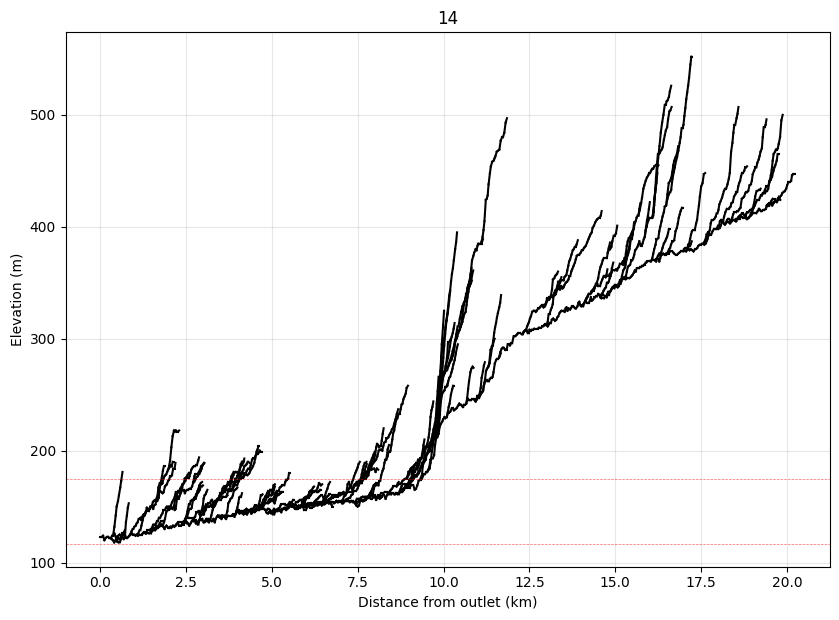

Plotted outlet: 14


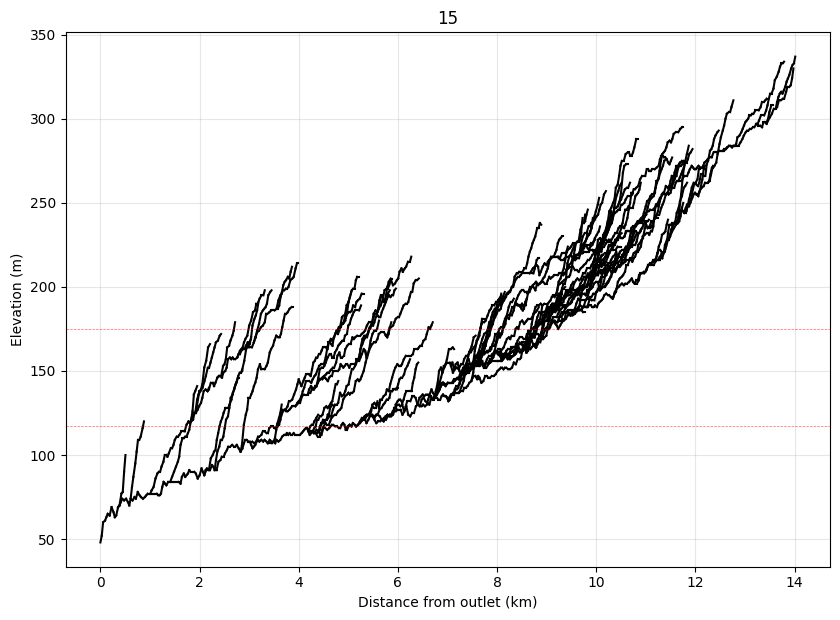

Plotted outlet: 15


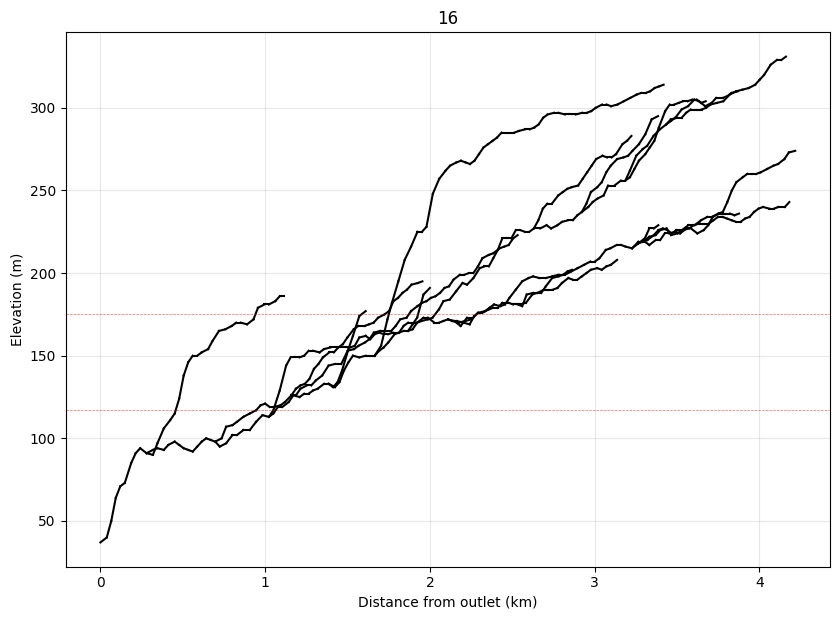

Plotted outlet: 16


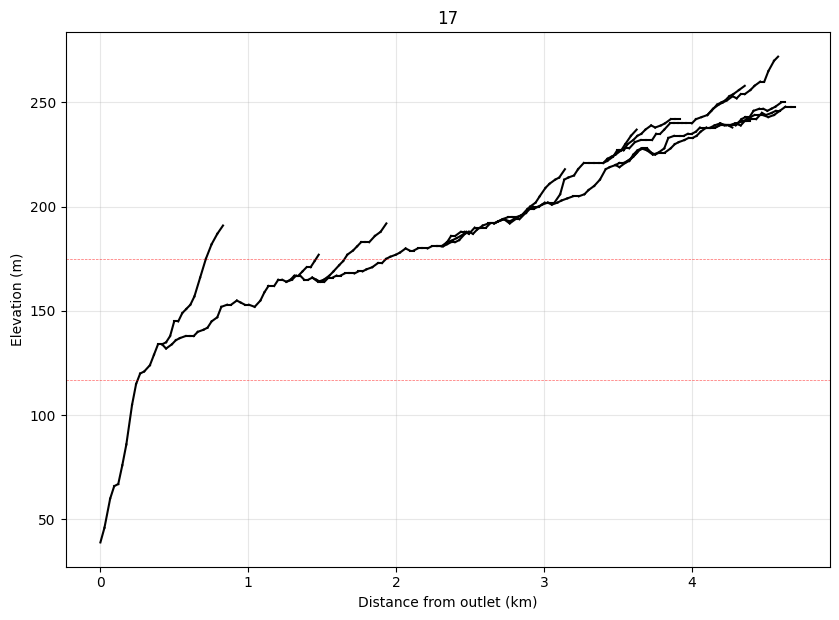

Plotted outlet: 17


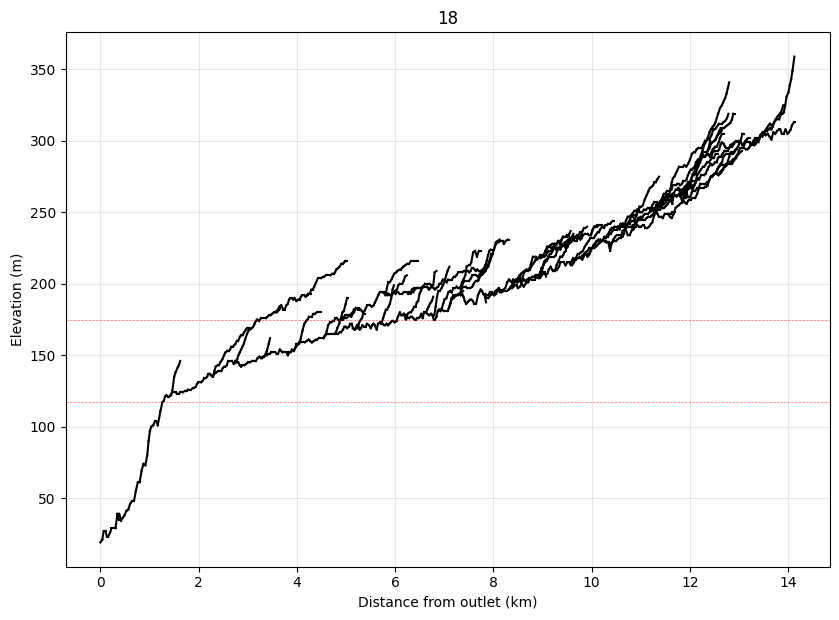

Plotted outlet: 18


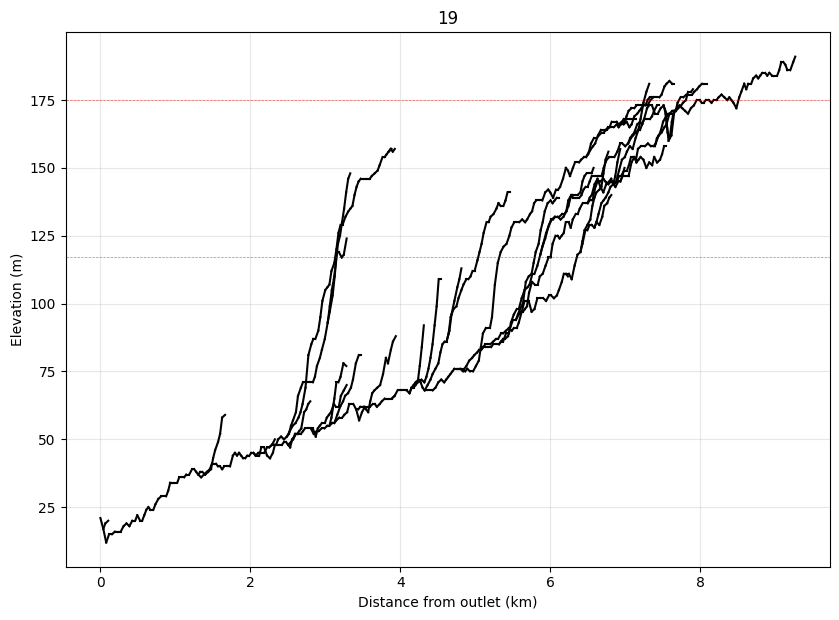

Plotted outlet: 19


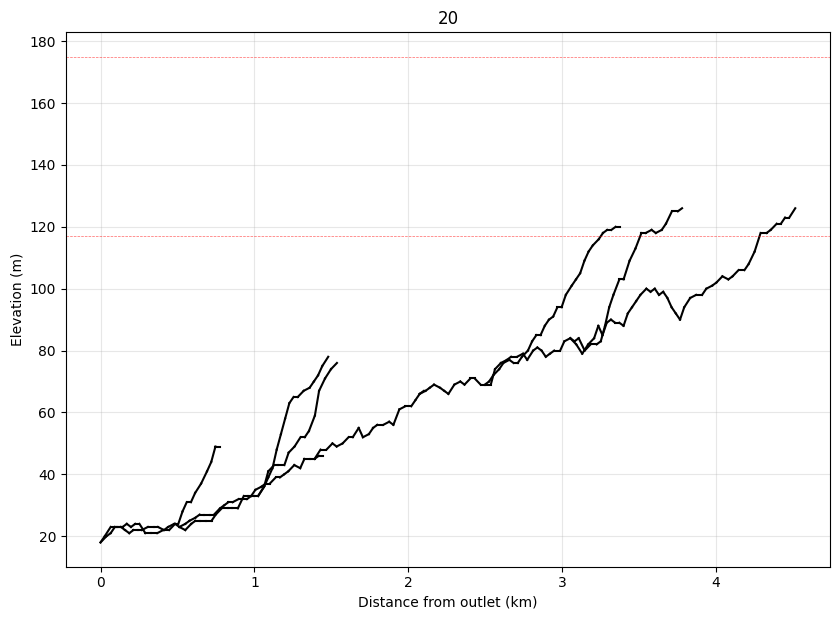

Plotted outlet: 20


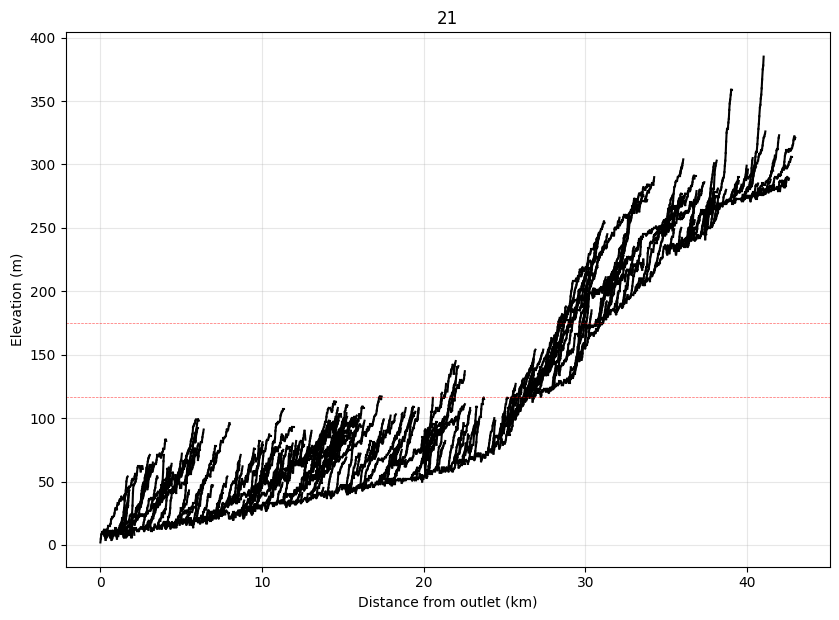

Plotted outlet: 21


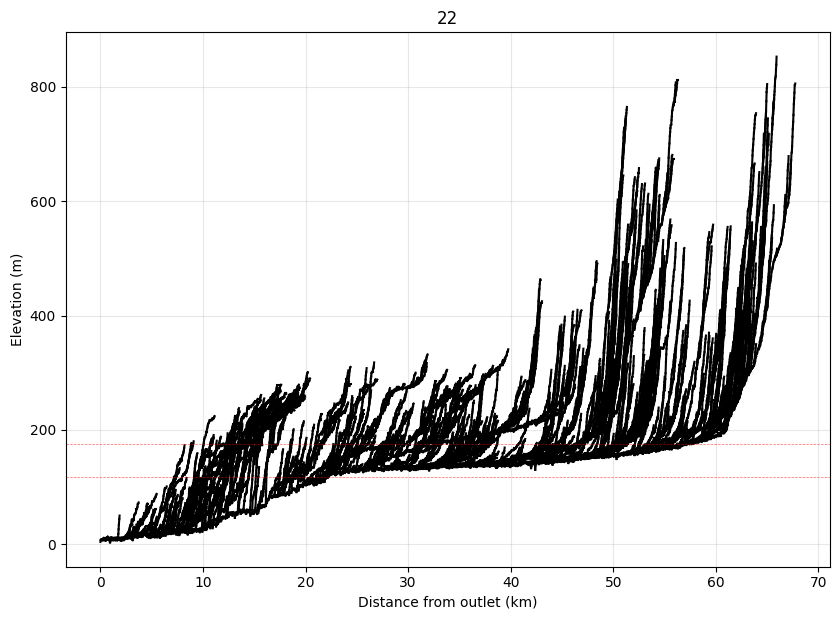

Plotted outlet: 22


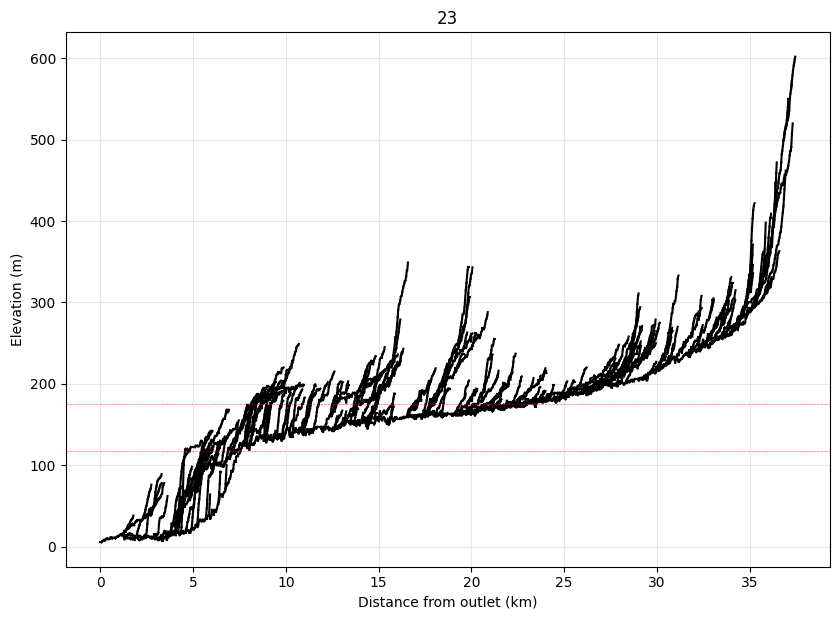

Plotted outlet: 23


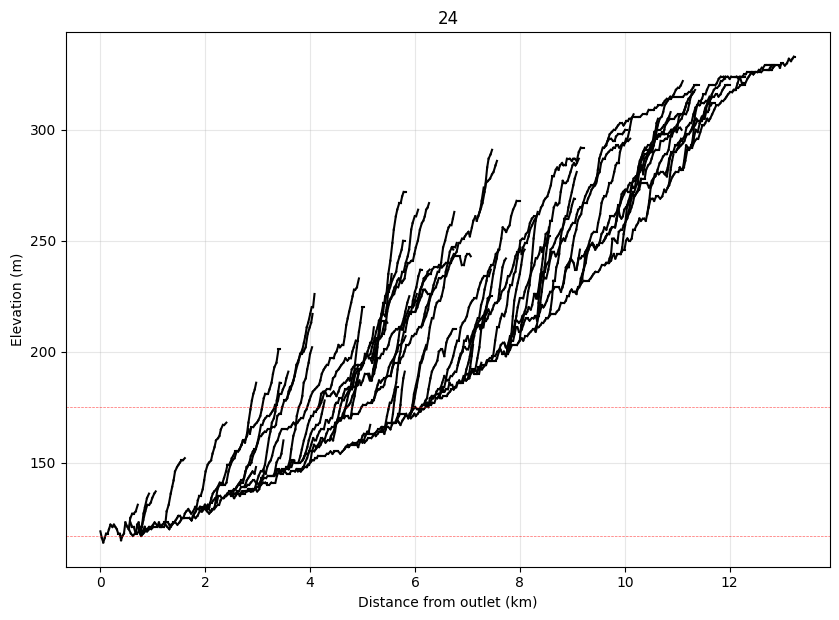

Plotted outlet: 24


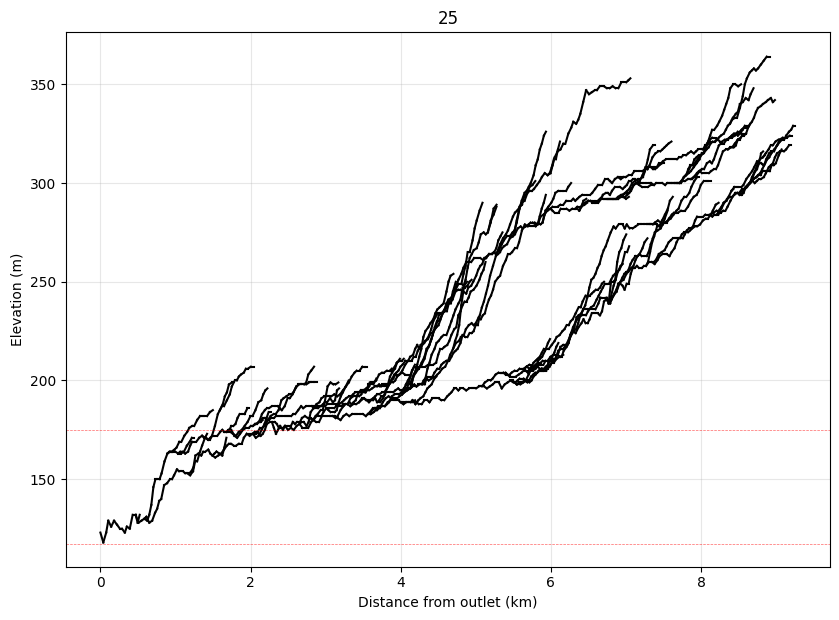

Plotted outlet: 25


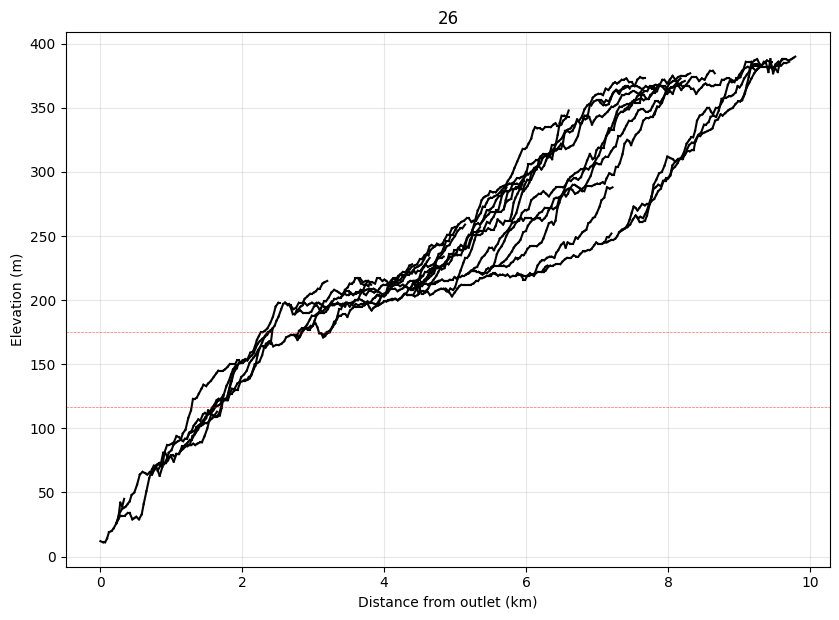

Plotted outlet: 26


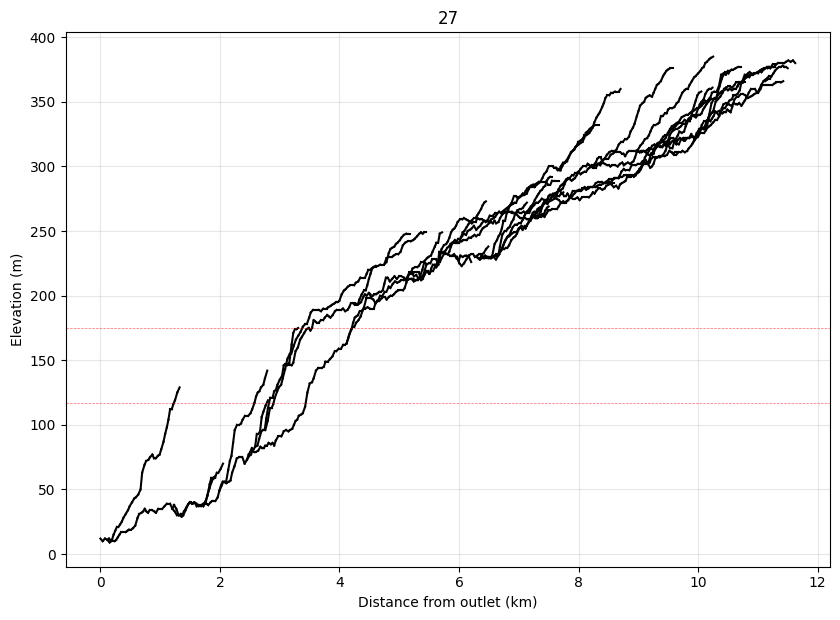

Plotted outlet: 27


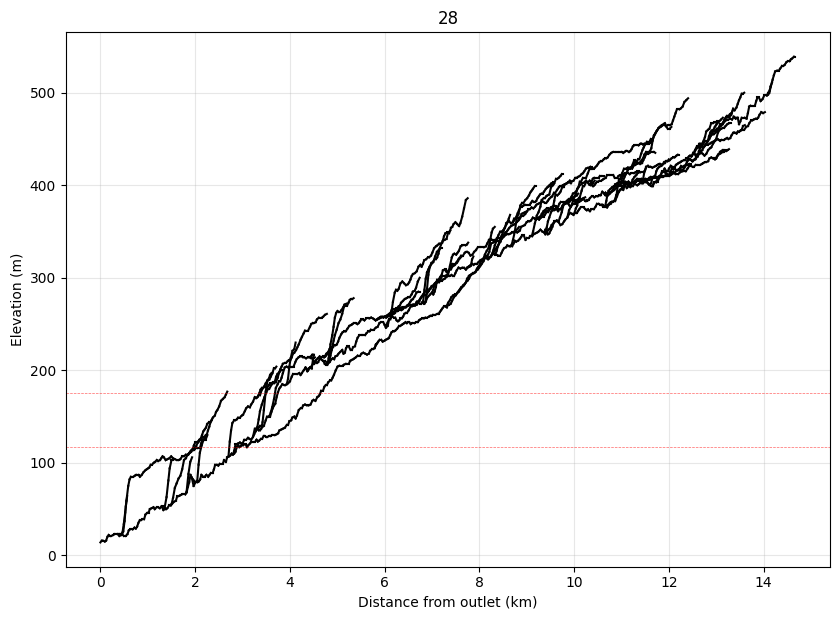

Plotted outlet: 28


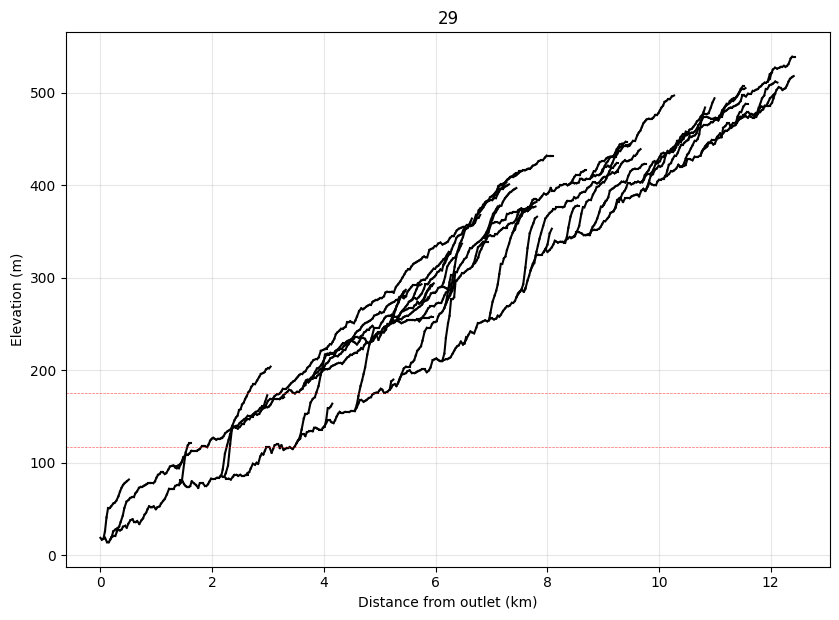

Plotted outlet: 29


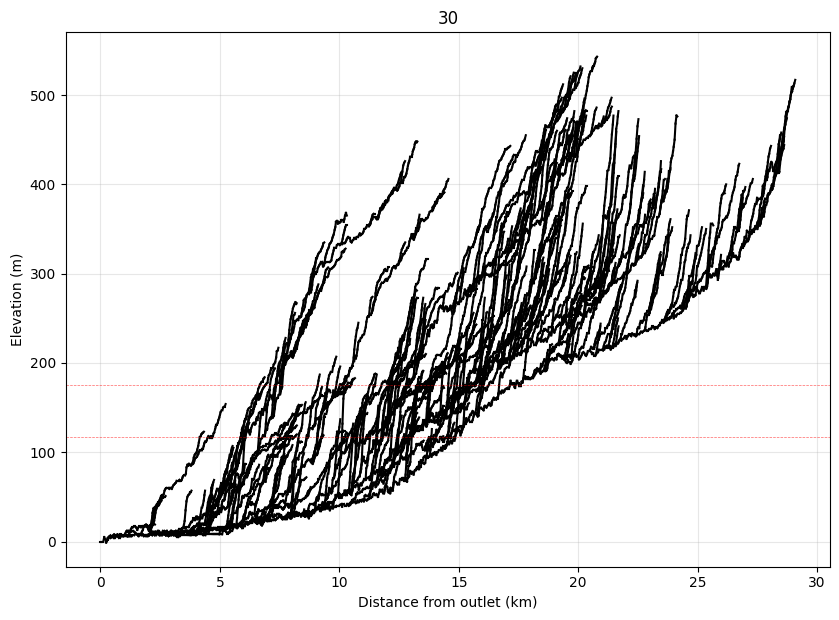

Plotted outlet: 30


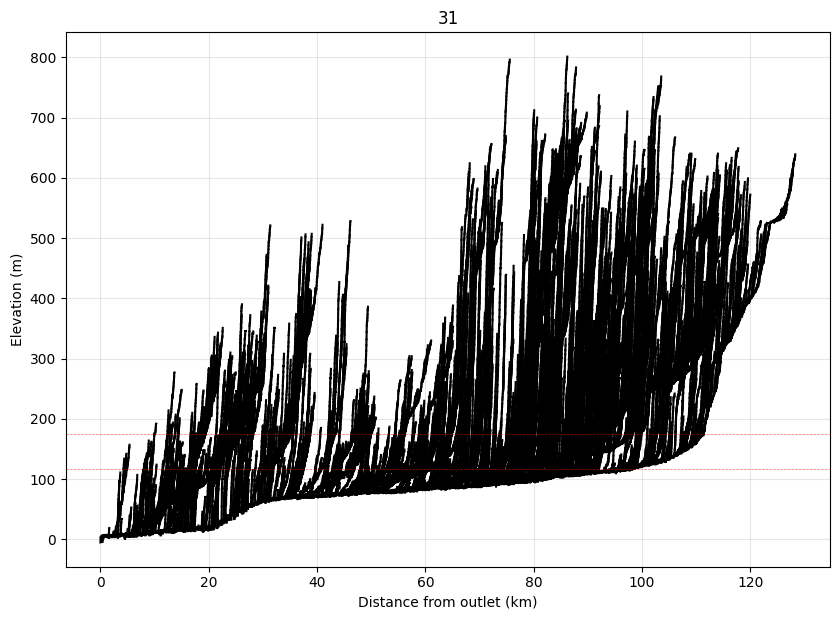

Plotted outlet: 31


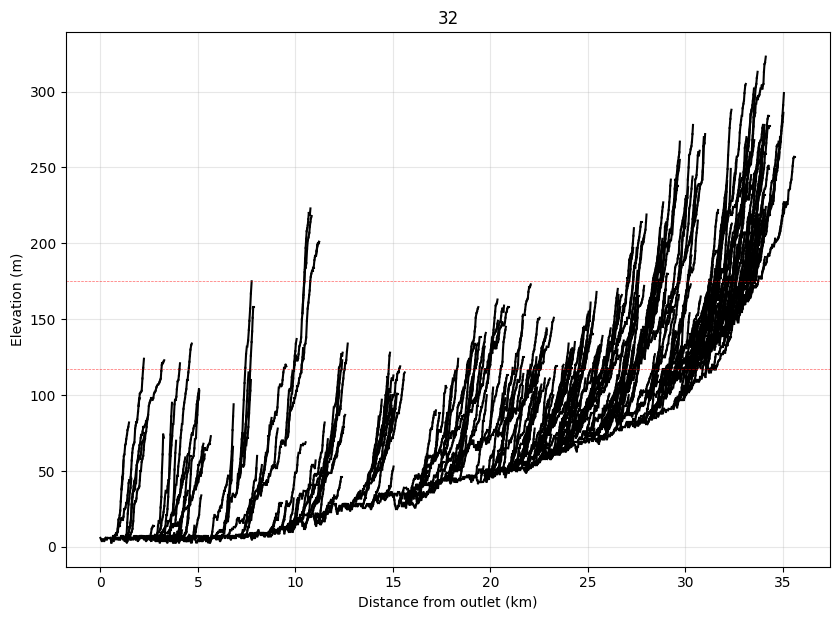

Plotted outlet: 32


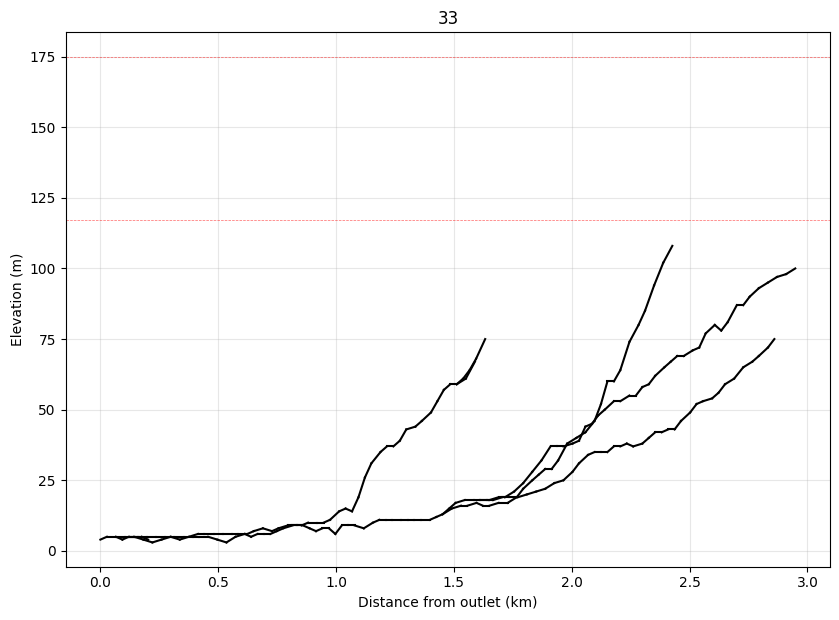

Plotted outlet: 33


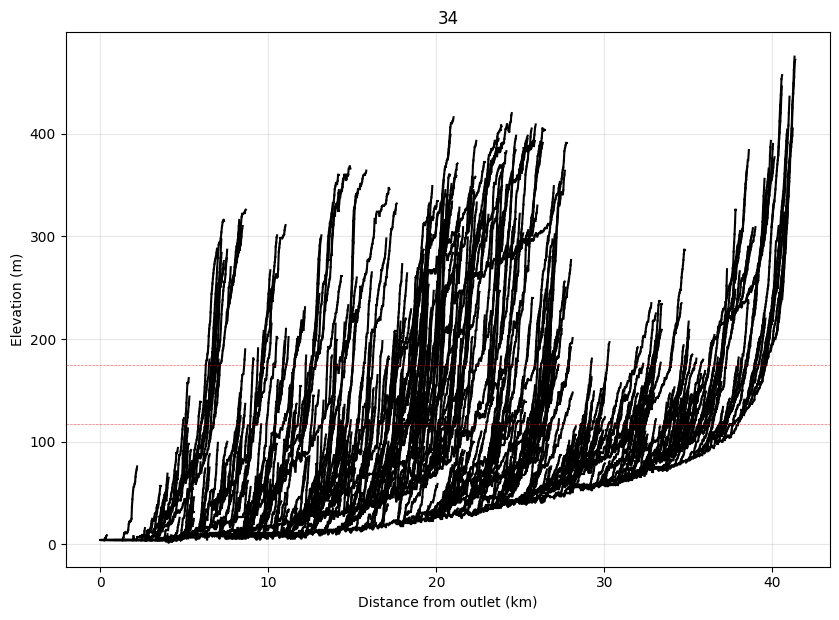

Plotted outlet: 34


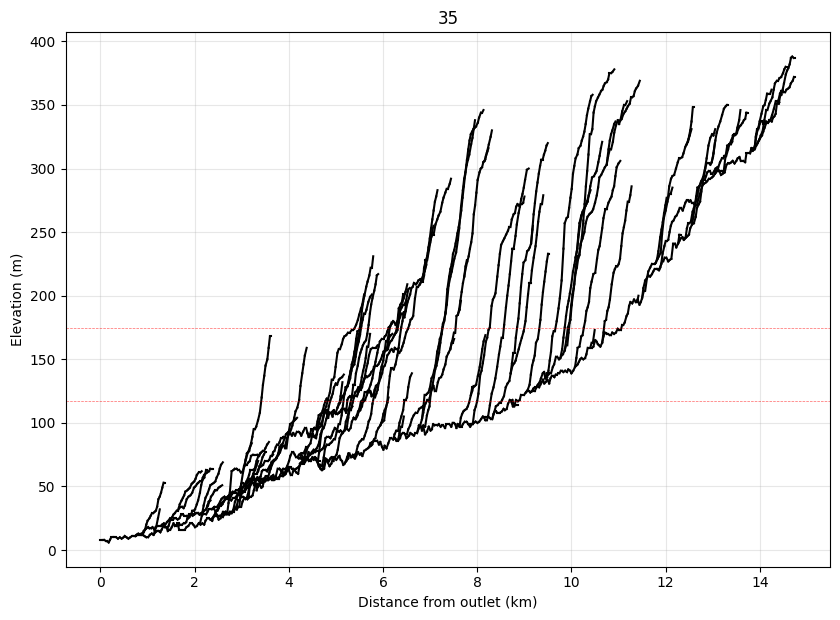

Plotted outlet: 35


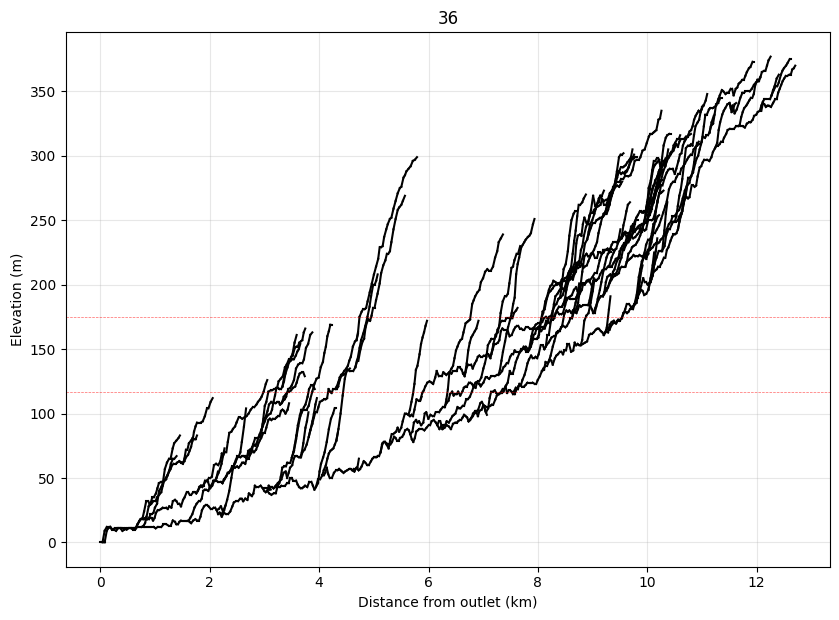

Plotted outlet: 36


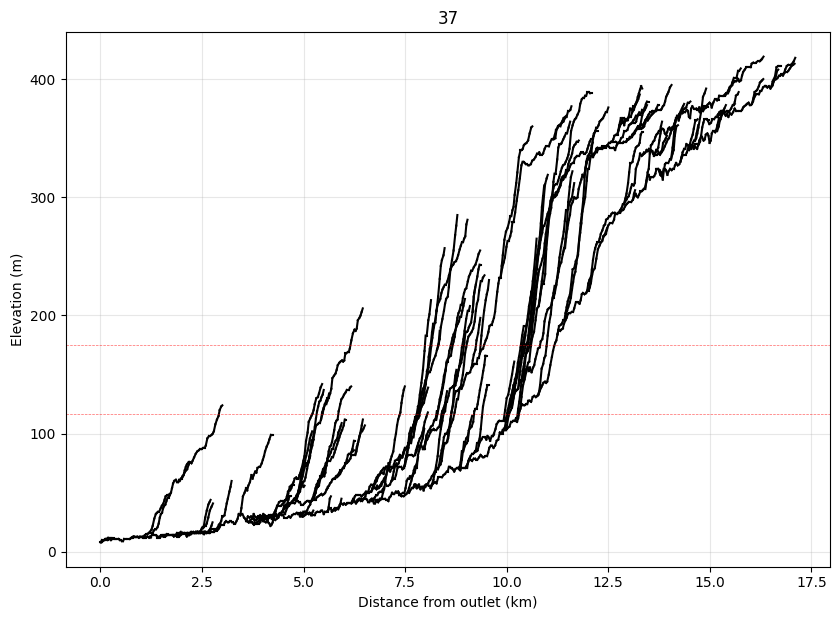

Plotted outlet: 37


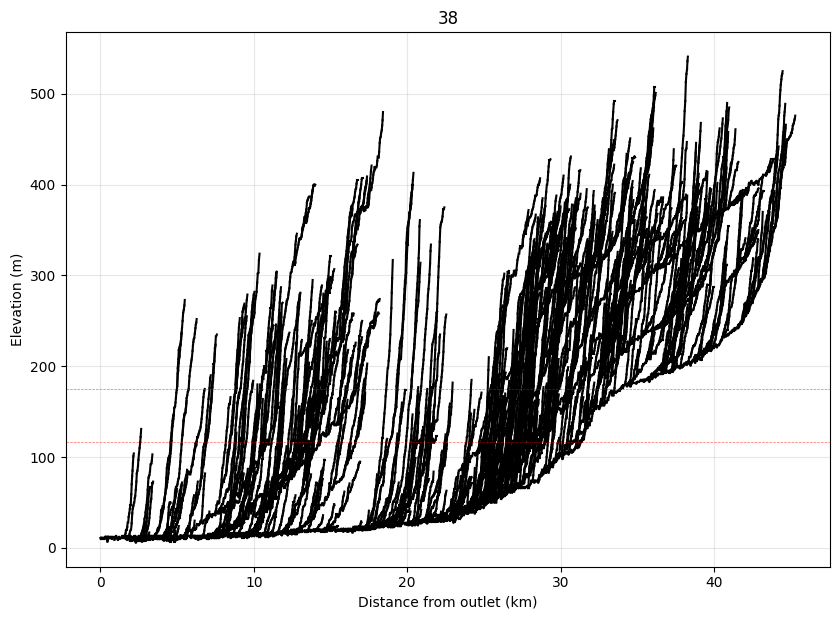

Plotted outlet: 38


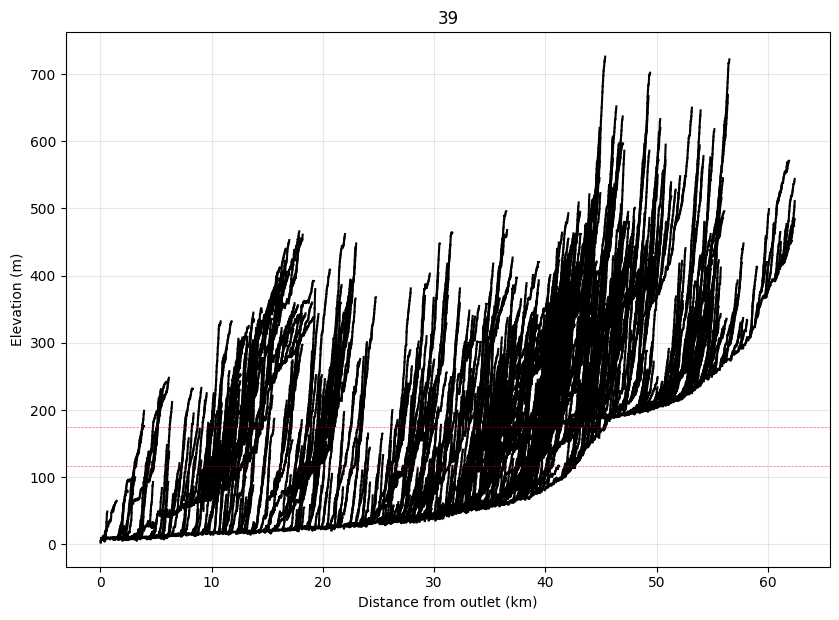

Plotted outlet: 39


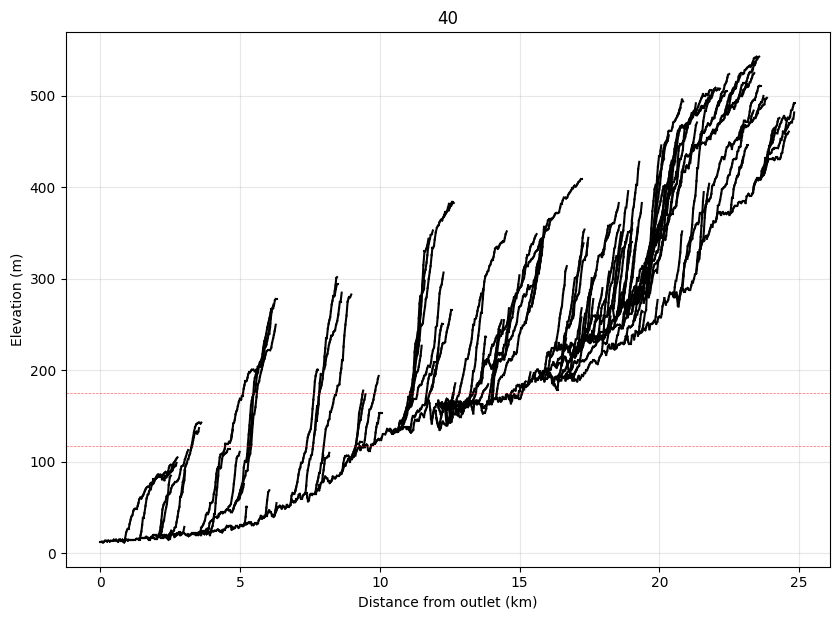

Plotted outlet: 40


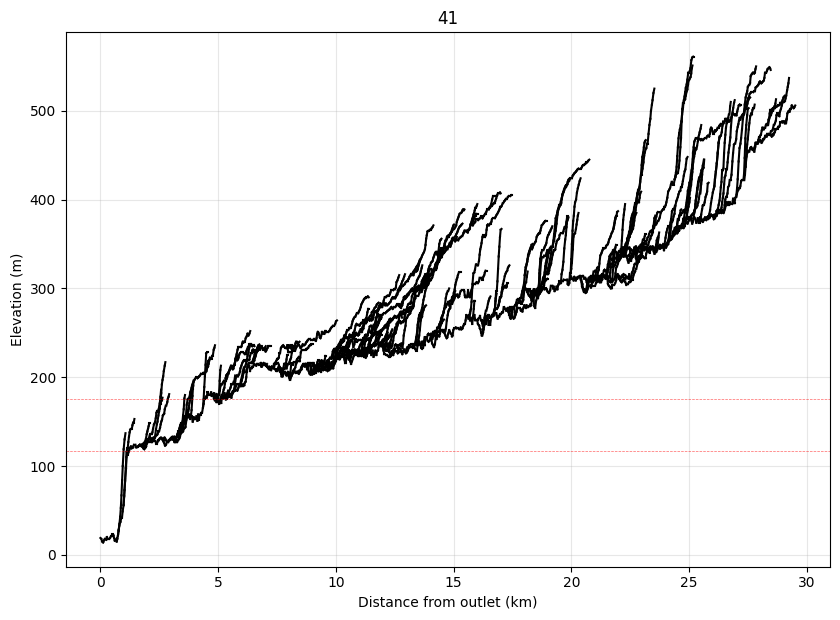

Plotted outlet: 41


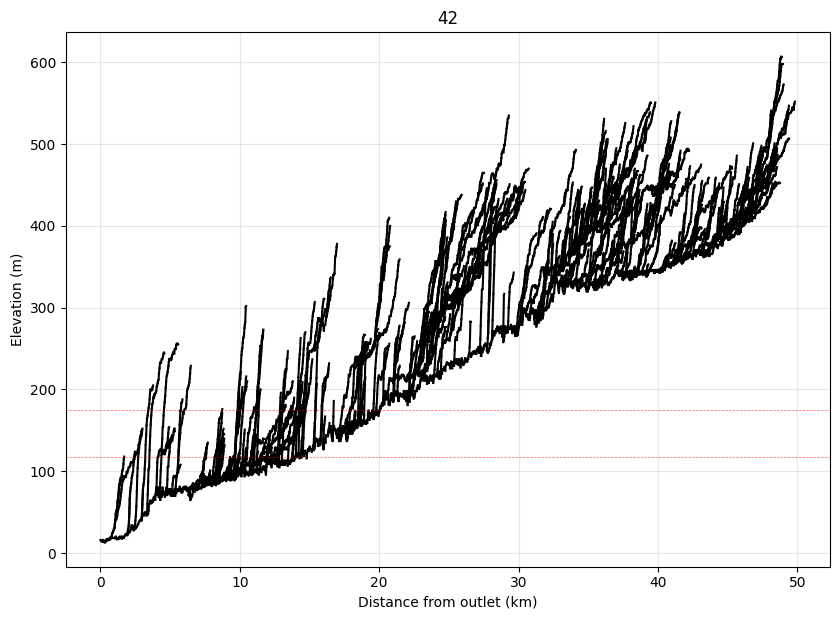

Plotted outlet: 42


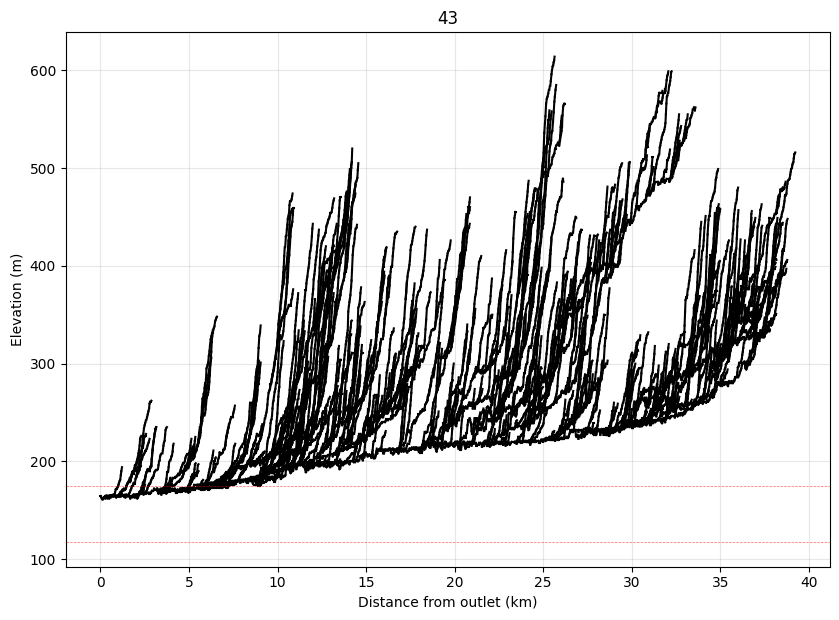

Plotted outlet: 43


In [35]:
# Plotting all river profiles including adjacent tributaries
def fix_indices_recursive(ld_item):
    """Fix malformed indices if they're wrapped in a tuple"""
    if isinstance(ld_item['index'], tuple) and len(ld_item['index']) == 1:
        ld_item['index'] = ld_item['index'][0]
    
    if ld_item.get('next'):
        for next_item in ld_item['next']:
            fix_indices_recursive(next_item)

def plot_upstream_profile(ld_list, minimum_area=1E5):
    """Plot river profile moving upstream"""
    def plot_recursive(current_distance, ld_item):
        if ld_item.get('next'):
            for next_item in ld_item['next']:
                if next_item['area'] >= minimum_area:
                    # Calculate distance to next point
                    current_row, current_col = ld_item['index']
                    next_row, next_col = next_item['index']
                    
                    # Diagonal movement is longer (sqrt(2) ≈ 1.414)
                    if (current_row != next_row) and (current_col != next_col):
                        distance_increment = ld_item['de'] * 1.414
                    else:
                        distance_increment = ld_item['de']
                    
                    next_distance = current_distance + distance_increment
                    
                    # Draw line segment (convert meters to km)
                    plt.plot([current_distance/1000, next_distance/1000], 
                           [ld_item['elevation'], next_item['elevation']], 
                           'k-')
                    
                    # Continue upstream
                    plot_recursive(next_distance, next_item)
    
    plot_recursive(0.0, ld_list)

# Setup mean pixel dimension
mean_pixel_dimension = d.BaseSpatialGrid()
mean_pixel_dimension._copy_info_from_grid(area, True)
mean_pixel_dimension._griddata = area._mean_pixel_dimension()

# Plot each outlet separately
for outlet_name, outlet_coords in outlets['outlets'].items():
    fig, ax = plt.subplots(1, figsize=(8.5, 6.3))
    
    # Get river network data
    ld_list = fd.map_values_to_recursive_list(
        outlet_coords, 
        elevation=dem, 
        area=area, 
        de=mean_pixel_dimension
    )
    fix_indices_recursive(ld_list)
    
    # Plot the profile
    plot_upstream_profile(ld_list, minimum_area=1E5)
    
    # Add dashed line at 175 m
    ax.axhline(y=175, color='red', linestyle='--', linewidth=0.5, alpha=0.6)
    ax.axhline(y=117, color='red', linestyle='--', linewidth=0.5, alpha=0.6)
    
    # Format the plot
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('Distance from outlet (km)')
    ax.set_ylabel('Elevation (m)')
    ax.set_title(outlet_name)
    
    plt.tight_layout()
    plt.show()
    
    print(f'Plotted outlet: {outlet_name}')

In [30]:
# Start from the outlet and manually trace upstream until we hit the error
def trace_upstream_debug(start_i, start_j, max_steps=10):
    current_i, current_j = start_i, start_j
    
    for step in range(max_steps):
        print(f"\nStep {step}: Cell ({current_i}, {current_j})")
        print(f"  dem: {dem[current_i, current_j]}")
        print(f"  area: {area[current_i, current_j]}")
        print(f"  mean_px: {mean_pixel_dimension[current_i, current_j]}")
        
        # Find upstream cells
        neighbors = [
            (current_i-1, current_j-1), (current_i-1, current_j), (current_i-1, current_j+1),
            (current_i, current_j-1),                              (current_i, current_j+1),
            (current_i+1, current_j-1), (current_i+1, current_j), (current_i+1, current_j+1)
        ]
        fd_values = [1, 2, 4, 8, 16, 32, 64, 128]
        
        upstream_cells = []
        for idx, (ni, nj) in enumerate(neighbors):
            try:
                if fd[ni, nj] == fd_values[idx]:
                    upstream_cells.append((ni, nj))
            except:
                pass
        
        print(f"  Found {len(upstream_cells)} upstream cells")
        
        if not upstream_cells:
            print("  No more upstream cells - reached headwater")
            break
        
        # Continue with first upstream cell
        current_i, current_j = upstream_cells[0]

trace_upstream_debug(4961, 4219)


Step 0: Cell (4961, 4219)
  dem: 9.0
  area: 38065449.075325556
  mean_px: 27.350566245475594
  Found 1 upstream cells

Step 1: Cell (4962, 4219)
  dem: 10.0
  area: 748.053473948149
  mean_px: 27.350566245475594
  Found 1 upstream cells

Step 2: Cell (4963, 4218)
  dem: 10.0
  area: 748.053473948149
  mean_px: 27.350566245475594
  Found 0 upstream cells
  No more upstream cells - reached headwater


In [17]:
# Creates csv files for the samples run above so that the exact knickpoint can be identified and plotting in QGIS

import csv

def extract_profile_data_with_coords(ld_list, dem_grid, minimum_area=1E5):
    """
    Extract river profile data INCLUDING the geographic coordinates.
    """
    data_points = []
    
    def extract_recursive(current_distance, ld_item):
        # Get the row/column indices
        row, col = ld_item['index']
        
        # Convert row/col to geographic coordinates
        # The method expects a list of (row, col) tuples and returns a list of (x, y) tuples
        xy_list = dem_grid._rowscols_to_xy([(row, col)])
        x, y = xy_list[0]  # Get the first (and only) result
        
        data_points.append({
            'distance_km': current_distance / 1000,
            'elevation_m': ld_item['elevation'],
            'drainage_area_m2': ld_item['area'],
            'x_coord': x,
            'y_coord': y
        })
        
        if ld_item.get('next'):
            for next_item in ld_item['next']:
                if next_item['area'] >= minimum_area:
                    current_row, current_col = ld_item['index']
                    next_row, next_col = next_item['index']
                    
                    if (current_row != next_row) and (current_col != next_col):
                        distance_increment = ld_item['de'] * 1.414
                    else:
                        distance_increment = ld_item['de']
                    
                    next_distance = current_distance + distance_increment
                    extract_recursive(next_distance, next_item)
    
    extract_recursive(0.0, ld_list)
    return data_points

# Save CSVs with coordinates
for outlet_name, outlet_coords in outlets['rapel'].items():
    ld_list = fd.map_values_to_recursive_list(
        outlet_coords, 
        elevation=dem, 
        area=area, 
        de=mean_pixel_dimension
    )
    fix_indices_recursive(ld_list)
    
    profile_data = extract_profile_data_with_coords(ld_list, dem, minimum_area=1E5)
    
    filename = f"{outlet_name.replace(' ', '_')}_profile_with_coords.csv"
    
    with open(filename, 'w', newline='') as csvfile:
        fieldnames = ['distance_km', 'elevation_m', 'drainage_area_m2', 'x_coord', 'y_coord']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(profile_data)
    
    print(f'Saved data to: {filename}')

Saved data to: RP-S2_profile_with_coords.csv
Saved data to: RP-S3_profile_with_coords.csv
Saved data to: RP-S3u_profile_with_coords.csv
Saved data to: RP-S4u_profile_with_coords.csv
Saved data to: 6_profile_with_coords.csv
Saved data to: 7_profile_with_coords.csv
Saved data to: 8_profile_with_coords.csv
Saved data to: 9_profile_with_coords.csv
Saved data to: 10_profile_with_coords.csv
Saved data to: 11_profile_with_coords.csv
Saved data to: 12_profile_with_coords.csv
Saved data to: 13_profile_with_coords.csv
Saved data to: 14_profile_with_coords.csv
Saved data to: 15_profile_with_coords.csv
Saved data to: 16_profile_with_coords.csv
Saved data to: 17_profile_with_coords.csv
Saved data to: 18_profile_with_coords.csv
Saved data to: 19_profile_with_coords.csv
Saved data to: 20_profile_with_coords.csv
Saved data to: 21_profile_with_coords.csv
Saved data to: 22_profile_with_coords.csv
Saved data to: 23_profile_with_coords.csv
Saved data to: Outlet_profile_with_coords.csv


## Plots RP-1 sample, treated as the outlet sample (whole Rapel, has associated erosion rate)

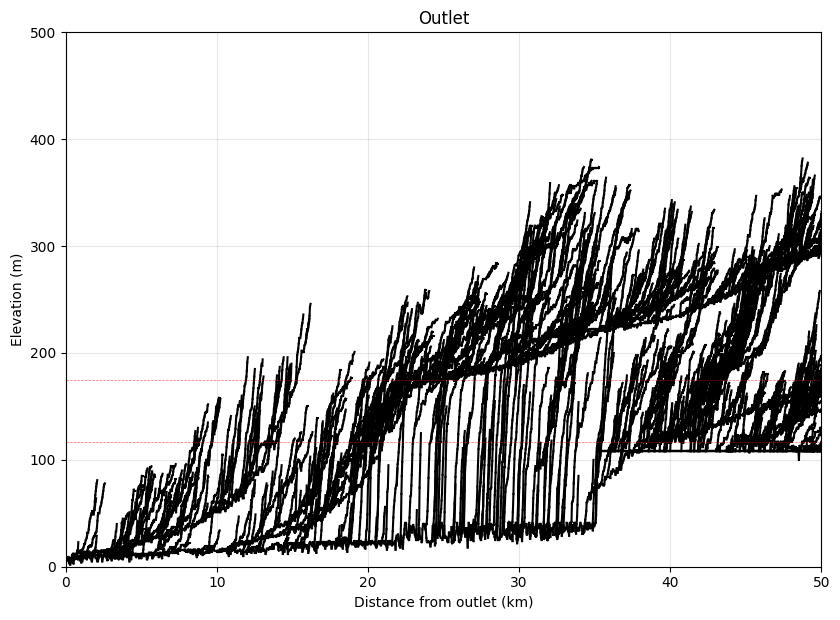

Plotted outlet: Outlet


In [21]:
outlets = {'rapel': {'Outlet': [240012.37420, 6244480.719]}
          }

# Plot each outlet separately
for outlet_name, outlet_coords in outlets['rapel'].items():
    fig, ax = plt.subplots(1, figsize=(8.5, 6.3))
    
    # Get river network data
    ld_list = fd.map_values_to_recursive_list(
        outlet_coords, 
        elevation=dem, 
        area=area, 
        de=mean_pixel_dimension
    )
    fix_indices_recursive(ld_list)
    
    # Plot the profile
    plot_upstream_profile(ld_list, minimum_area=1E5)
    
    # Add dashed line at 175 m
    ax.axhline(y=175, color='red', linestyle='--', linewidth=0.5, alpha=0.6)
    ax.axhline(y=117, color='red', linestyle='--', linewidth=0.5, alpha=0.6)
    
    # Zoom in to first 50 km
    ax.set_xlim(0, 50)
    ax.set_ylim(0, 500)
    
    # Format the plot
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('Distance from outlet (km)')
    ax.set_ylabel('Elevation (m)')
    ax.set_title(outlet_name)
    
    plt.tight_layout()
    plt.show()
    
    print(f'Plotted outlet: {outlet_name}')

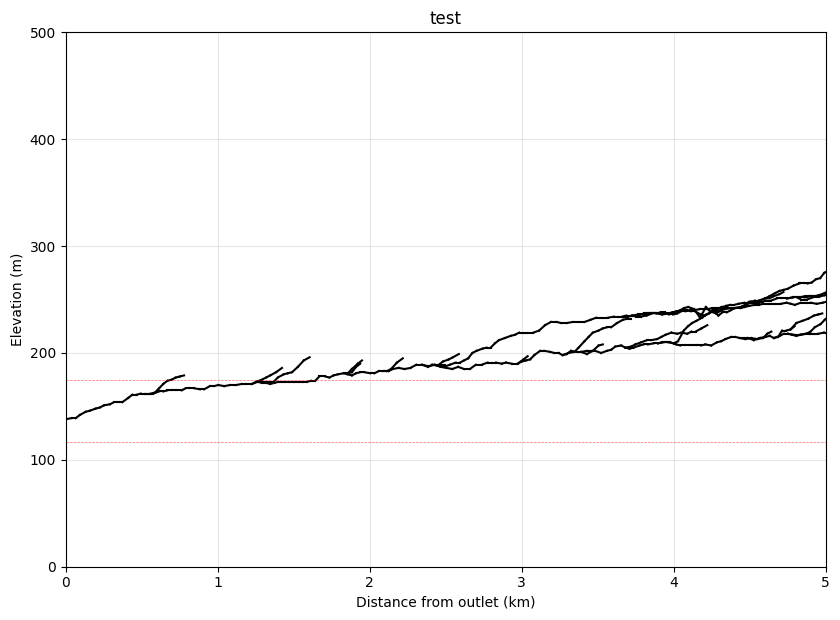

Plotted outlet: test


In [12]:
outlets = {'rapel': {'test': [251290, 6235042]}
          }

# Plot each outlet separately
for outlet_name, outlet_coords in outlets['rapel'].items():
    fig, ax = plt.subplots(1, figsize=(8.5, 6.3))
    
    # Get river network data
    ld_list = fd.map_values_to_recursive_list(
        outlet_coords, 
        elevation=dem, 
        area=area, 
        de=mean_pixel_dimension
    )
    fix_indices_recursive(ld_list)
    
    # Plot the profile
    plot_upstream_profile(ld_list, minimum_area=1E5)
    
    # Add dashed line at 175 m
    ax.axhline(y=175, color='red', linestyle='--', linewidth=0.5, alpha=0.6)
    ax.axhline(y=117, color='red', linestyle='--', linewidth=0.5, alpha=0.6)
    
    # Zoom in to first 50 km
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 500)
    
    # Format the plot
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('Distance from outlet (km)')
    ax.set_ylabel('Elevation (m)')
    ax.set_title(outlet_name)
    
    plt.tight_layout()
    plt.show()
    
    print(f'Plotted outlet: {outlet_name}')